<a href="https://colab.research.google.com/github/silvsilvsilv/multilingualcodeswitchingthesis/blob/main/XLM_Roberta_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# 1️⃣ Setup & Install Dependencies
# ============================================================

!pip install transformers datasets evaluate torch torchvision torchaudio scikit-learn matplotlib pandas seaborn -q

import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, set_seed
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import random
import os
from tqdm import tqdm

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


✅ Using device: cuda


In [ ]:
# ============================================================
# 2️⃣  Load the pre-split datasets
# ============================================================

train_df = pd.read_csv("unique_train_dataset.csv")
val_df   = pd.read_csv("unique_validation_dataset.csv")
test_df  = pd.read_csv("unique_test_dataset.csv")

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)

# Preview structure
train_df.head()


Train: (21773, 2)
Validation: (2800, 2)
Test: (2810, 2)


,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


In [ ]:
# ============================================================
# 3️⃣ Tokenization Function
# ============================================================

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

def prepare_dataset(df):
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(tokenize_function, batched=True)
    remove_cols = [col for col in dataset.column_names if col not in ['input_ids','attention_mask','label']]
    dataset = dataset.remove_columns(remove_cols)
    dataset.set_format("torch")
    return dataset

train_dataset = prepare_dataset(train_df)
val_dataset   = prepare_dataset(val_df)
test_dataset  = prepare_dataset(test_df)


Map:   0%|          | 0/21773 [00:00<?, ? examples/s]

Map:   0%|          | 0/2800 [00:00<?, ? examples/s]

Map:   0%|          | 0/2810 [00:00<?, ? examples/s]

In [ ]:
# ============================================================
# 4️⃣ Define Evaluation Metrics
# ============================================================

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    precision, recall, f1_macro, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    _, _, f1_micro, _ = precision_recall_fscore_support(labels, preds, average="micro", zero_division=0)
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro
    }



🚀 Starting Trial 1


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro,F1 Micro
1,0.386000,0.353908,0.857143,0.858493,0.856813,0.856914,0.857143
2,0.292400,0.340661,0.865357,0.870668,0.864718,0.864714,0.865357
3,0.237200,0.364765,0.869286,0.869581,0.869133,0.869213,0.869286


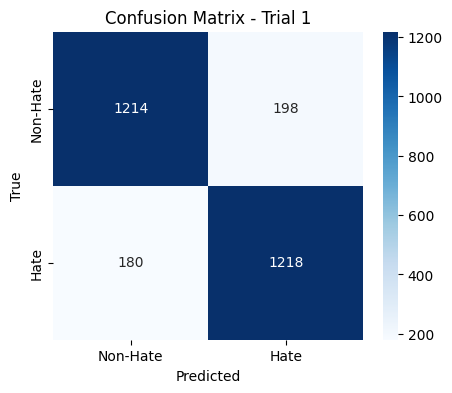


🚀 Starting Trial 2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro,F1 Micro
1,0.381800,0.377274,0.849286,0.860449,0.848342,0.847850,0.849286
2,0.302700,0.345354,0.865357,0.865338,0.865361,0.865346,0.865357
3,0.218800,0.370047,0.869286,0.869581,0.869133,0.869213,0.869286


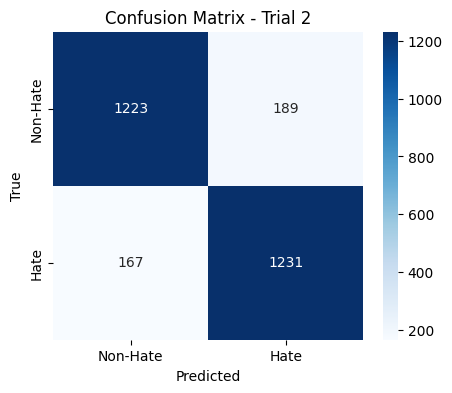


🚀 Starting Trial 3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro,F1 Micro
1,0.392000,0.353144,0.857500,0.859015,0.857151,0.857251,0.857500
2,0.293400,0.343522,0.868214,0.871101,0.867744,0.867840,0.868214
3,0.229800,0.377833,0.866071,0.866720,0.865846,0.865948,0.866071


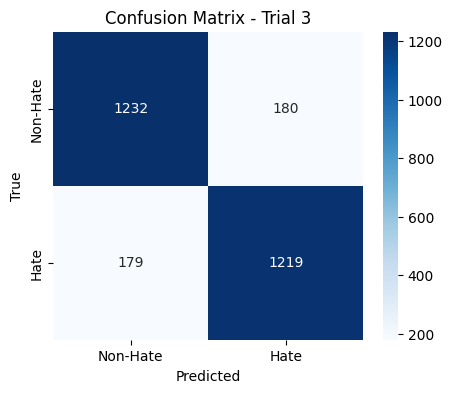


🚀 Starting Trial 4


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro,F1 Micro
1,0.377200,0.329416,0.856071,0.862148,0.855378,0.855280,0.856071
2,0.284600,0.311066,0.871071,0.871245,0.870953,0.871018,0.871071
3,0.229700,0.354664,0.871429,0.873757,0.871008,0.871125,0.871429


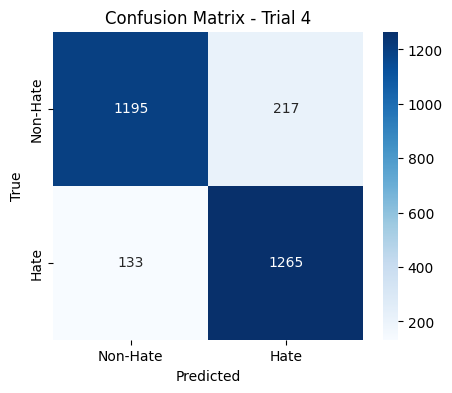


🚀 Starting Trial 5


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro,F1 Micro
1,0.395400,0.329559,0.850714,0.852227,0.850360,0.850449,0.850714
2,0.303900,0.326255,0.869643,0.870444,0.869394,0.869505,0.869643
3,0.228700,0.352981,0.867500,0.868295,0.867251,0.867360,0.867500


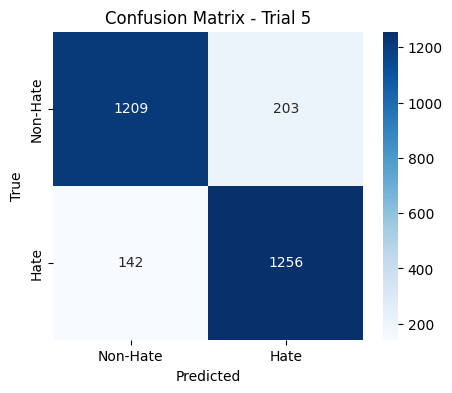

In [ ]:
# ============================================================
# 5️⃣ Run 5 Trials with Different Random Seeds
# ============================================================

# Make sure results folder exists
os.makedirs("results/confusion_matrices", exist_ok=True)

all_results = []

for trial in range(1, 6):
    print(f"\n==============================")
    print(f"🚀 Starting Trial {trial}")
    print(f"==============================")

    # Set different random seeds for each trial
    seed = 42 + trial
    set_seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Load fresh model each trial
    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2).to(device)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_trial_{trial}",
        eval_strategy="epoch",
        save_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir=f"./logs_trial_{trial}",
        seed=seed,
        disable_tqdm=False,
        log_level="error"
    )

    # Trainer setup
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train
    trainer.train()

    # Evaluate on test set
    results = trainer.evaluate(test_dataset)
    all_results.append(results)

    # Confusion matrix for this trial
    preds_output = trainer.predict(test_dataset)
    preds = np.argmax(preds_output.predictions, axis=1)
    labels = preds_output.label_ids

    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate','Hate'], yticklabels=['Non-Hate','Hate'])
    plt.title(f"Confusion Matrix - Trial {trial}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Save confusion matrix as CSV
    cm_df = pd.DataFrame(cm, index=["Actual_0", "Actual_1"], columns=["Pred_0", "Pred_1"])
    cm_df.to_csv(f"results/confusion_matrices/confusion_matrix_trial_{trial}.csv", index=True)


In [ ]:
# ============================================================
# 6️⃣ Aggregate Results: Mean ± Std
# ============================================================

df_results = pd.DataFrame(all_results)
df_results = df_results[["eval_accuracy", "eval_precision", "eval_recall", "eval_f1_macro", "eval_f1_micro"]]
df_results.columns = ["Accuracy", "Precision", "Recall", "Macro-F1", "Micro-F1"]

mean = df_results.mean()
std = df_results.std()

summary = pd.DataFrame({
    "Metric": mean.index,
    "Mean": mean.values,
    "Std": std.values,
    "Formatted": [f"{m:.4f} ± {s:.4f}" for m, s in zip(mean.values, std.values)]
})

print("\n📊 Mean ± Std across 5 trials:")
display(summary)

df_results.to_csv("roberta_5trials_metrics.csv", index=False)
summary.to_csv("roberta_5trials_summary.csv", index=False)
print("✅ Saved detailed results (per trial) and summary (mean ± std).")



📊 Mean ± Std across 5 trials:


,Metric,Mean,Std,Formatted
0,Accuracy,0.872740,0.004492,0.8727 ± 0.0045
1,Precision,0.873146,0.004851,0.8731 ± 0.0049
2,Recall,0.872803,0.004530,0.8728 ± 0.0045
3,Macro-F1,0.872717,0.004472,0.8727 ± 0.0045
4,Micro-F1,0.872740,0.004492,0.8727 ± 0.0045


✅ Saved detailed results (per trial) and summary (mean ± std).
